# Libraries and Functions

In [1]:
# Base Libs
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from IPython.display import display, clear_output

# Ordinal Patterns
import ordpy                                                                            # Ordinal Pattern Transformation
import networkx as nx                                                                   # Graphs

# Scikit Learn
from sklearn.svm import OneClassSVM                                                     # One Class SVM
from sklearn.metrics import confusion_matrix                                            # Results
from sklearn.metrics import classification_report                                       # |
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score     # |
from sklearn.metrics import ConfusionMatrixDisplay                                      # |
from sklearn.model_selection import train_test_split                                    # Train and Test Split
from sklearn.ensemble import RandomForestClassifier                                     # RFC
from sklearn.linear_model import Lasso                                                  # LASSO
from sklearn.decomposition import PCA                                                   # PCA
from sklearn.feature_selection import f_classif                                         # ANOVA
from sklearn.feature_selection import SelectKBest, chi2, f_classif                      # chi2
from skrebate import ReliefF, MultiSURF                                                 # ReliefF, MultiSURF
from sklearn.feature_selection import SelectPercentile, mutual_info_classif             # Information Gain

# Scipy
from scipy.stats import pearsonr, f_oneway                                              # Pearson correlation
from scipy.stats import entropy                                                         # Entropy

# XGBoost
from xgboost import XGBClassifier                                                       # XGBoost
from xgboost import plot_importance                                                     # Plot importance based on fitted trees

**scikit-rebate:** *Urbanowicz, Ryan J., et al. "Benchmarking relief-based feature selection methods for bioinformatics data mining." Journal of biomedical informatics 85 (2018): 168-188.*

**ordpy:** *A. A. B. Pessa, H. V. Ribeiro, ordpy: A Python package for data analysis with permutation entropy and ordinal network methods, Chaos 31, 063110 (2021). arXiv:2102.06786*

In [2]:
# Convert seconds to minutes and seconds
def predict(seconds):
    minutes = seconds // 60
    seconds_remaining = seconds % 60
    return minutes, seconds_remaining

In [3]:
# Execute feature selection
def feature_selection(df, metodo = "rfc", col_timestamp = False, alpha_value = 0.1, n_pca_components=None):
    # Separate features (X) and labels (y)
    if(col_timestamp):
        X = df.drop(['label', 'timestamp'], axis=1)
    else:
        X = df.drop(['label'], axis=1)
    y = df['label']
    
    # Divides the data into training (30%) and testing (70%) sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.33, random_state=42) # random_state for replication
    
    if(metodo == "rfc"):
        # Train the model
        rf_model = RandomForestClassifier(random_state=24)
        rf_model.fit(X_train, y_train)
        
        # Get features importance
        importances = rf_model.feature_importances_
    elif(metodo == "lasso"):
        # Train the model
        lasso_model = Lasso(alpha = alpha_value, random_state=24 )  # O valor de alpha pode ser ajustado
        lasso_model.fit(X_train, y_train)
        
        # Get features importance
        importances = np.abs(lasso_model.coef_)
    elif(metodo == "xgboost"):
        # Train the model
        xgb_model = XGBClassifier(random_state=24)
        xgb_model.fit(X_train, y_train)
        
        # Get features importance
        importances = xgb_model.feature_importances_
    elif metodo == "pca":
        # Apply PCA
        pca = PCA(n_components=n_pca_components)
        X_train_pca = pca.fit_transform(X_train)

        # Get features importance
        importances = np.sum(np.abs(pca.components_), axis=0)
    elif metodo == "anova":
        # Apply ANOVA
        f_values, _ = f_classif(X_train, y_train)

        # Get features importance using F-values
        importances = f_values
    elif metodo == "relieff":
        # Transform to ndarray
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        
        # Apply RefiefF
        relief = ReliefF()
        relief.fit(X_train, y_train)
        
        # Get features importance
        importances = relief.feature_importances_

    elif metodo == "multisurf":
        # Transform to ndarray
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        
        # Apply MultiSURF
        multi_surf = MultiSURF()
        multi_surf.fit(X_train, y_train)
        
        # Get features importance
        importances = multi_surf.feature_importances_

    elif metodo == "chi2":
        # Get features importance
        importances, _ = chi2_scores, _ = chi2(X_train, y_train)
        
    elif metodo == "ig":
        # Get features importance
        importances = mutual_info_classif(X_train, y_train)

    elif metodo == "pc":
        # Transform to ndarray
        X_train = np.array(X_train)
        y_train = np.array(y_train)

        # Get features importance
        importances = np.array([pearsonr(X_train[:, i], y_train)[0] for i in range(X_train.shape[1])])

    else:
        print("Error: Invalid Feature Selection Method")
        return
    
    # Build a dataframe
    importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    
    # Sort the dataframe by importance
    importances_df = importances_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
    
    # Return the sorted features
    return importances_df

In [4]:
# Function to execute the experiments
def experiment(df, features, col_timestamp = False, less = False):
    # Remove timestamp column
    if(col_timestamp):
        df = df.drop('timestamp', axis=1)

    # Divide the Training and Test sets
    # We want to evaluate detection over time, so shuffle = False
    # 1/3 of the dataset for training
    X = df[features]
    y = df['label']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.33, shuffle=False)

    # Train the model
    clf = OneClassSVM(gamma='auto', kernel='poly', nu=0.05).fit(X_train)
    
    # Test the model
    predictions = clf.predict(X_test)
    
    # Normalizes predictions
    predictions_norm = [0 if i == 1 else 1 for i in predictions]
    
    # Get the metrics
    accuracy = accuracy_score(y_test ,predictions_norm) * 100
    weighted_precision = precision_score(y_test, predictions_norm, average='weighted') * 100
    weighted_recall = recall_score(y_test, predictions_norm, average='weighted') * 100
    weighted_f1_score = f1_score(y_test, predictions_norm, average='weighted') * 100

    # Calculate prediction time
    outlier_indices = np.where(np.array(predictions_norm) == 1)[0]
    cut = int(len(df)*0.33)
    offset = outlier_indices + cut
    maligno = df.loc[offset]
    certo = maligno.loc[maligno["label"] == 1]
    # If at least one malign interval has correctly classified
    if(len(certo) != 0):
        tempo = len(df) - certo.index[0]
        # Result array
        result = [accuracy, weighted_precision, weighted_recall, weighted_f1_score, tempo]
        # Return result
        return result

    # Result array
    result = [accuracy, weighted_precision, weighted_recall, weighted_f1_score, 0]

    # Return result
    return result

# Dataset building - Traffic Captures Processing

The CTU13 captures can be downloaded at: https://www.stratosphereips.org/datasets-ctu13

"An empirical comparison of botnet detection methods" Sebastian Garcia, Martin Grill, Jan Stiborek and Alejandro Zunino. Computers and Security Journal, Elsevier. 2014. Vol 45, pp 100-123. http://dx.doi.org/10.1016/j.cose.2014.05.011

## Divide the captures (.pcap) by the range (1s for this article)

```editcap -i 1 input.pcap output-prefix```

Change input.pcap and output-prefix

## Transform .pcaps to .csv

Save the script above in a file with the .sh extension, give it execution permission with the command ```chmod +x your_script.sh``` and then run the script with ```./your_script.sh```. It will iterate through the desired files and run the tshark command for each one, generating output files named according to the index.

**Reminder:** Replace input_dir and output_dir with their corresponding directories

In [ ]:
output_dir = "ctu13/output/" # Replace with the folder where the .csv files are located
files = sorted(os.listdir(output_dir))

i = 0
matriz = []

for filename in files:
    if filename.endswith(".csv"):
        file_path = os.path.join(output_dir, filename)
        df = pd.read_csv(file_path, delimiter=';')

        # Cleaning
        df['srcport'] = df['udp.srcport'].fillna(df['tcp.srcport'])
        df['destport'] = df['udp.dstport'].fillna(df['tcp.dstport'])
        df = df.drop(columns=['udp.srcport', 'tcp.srcport', 'udp.dstport', 'tcp.dstport'])
        df = df.fillna(0)

        # Type Correction
        flag_columns = ["tcp.flags.res", "tcp.flags.ae", "tcp.flags.cwr", "tcp.flags.ece", "tcp.flags.urg",
                        "tcp.flags.ack", "tcp.flags.push", "tcp.flags.reset", "tcp.flags.syn", "tcp.flags.fin"]
        for column in flag_columns:
            df[column] = df[column].astype(int)

        int_columns = ["destport", "srcport", "tcp.seq"]
        for column in int_columns:
            df[column] = df[column].astype(int)

        df["ip.ttl"] = df["ip.ttl"].astype(str)
        df["ip.ttl"] = df["ip.ttl"].str.replace(',','.').astype(float)

        # Features array
        features = []

        # Total packets
        features.append(len(df))

        # Protocol features
        tcp = (df["frame.protocols"] == 'eth:ethertype:ip:tcp').sum()
        porcentagem_tcp = (tcp / len(df["frame.protocols"])) * 100
        features.append(porcentagem_tcp)

        udp = (df["frame.protocols"] == 'eth:ethertype:ip:udp').sum()
        porcentagem_udp = (udp / len(df["frame.protocols"])) * 100
        features.append(porcentagem_udp)

        outros = ((df["frame.protocols"] != 'eth:ethertype:ip:tcp') & (df["frame.protocols"] != 'eth:ethertype:ip:udp')).sum()
        porcentagem_outros = (outros / len(df["frame.protocols"])) * 100
        features.append(porcentagem_outros)

        # IP and MAC features
        address_columns = ["ip.src", "ip.dst", "eth.src", "eth.dst"]
        for column in address_columns:
            features.append(df[column].nunique())

        # Numeric features
        columns_numeric = ["frame.len", "frame.time_delta", "ip.ttl"]

        for column in columns_numeric:
            mean = df[column].mean()
            std = df[column].std()
            var = df[column].var()
            min = df[column].min()
            max = df[column].max()
            pquartil = df[column].quantile(0.25)
            med = df[column].quantile(0.5)
            tquartil = df[column].quantile(0.75)
            add = [mean, std, var, min, max, pquartil, med, tquartil]
            features.extend(add)

        # Flags features
        for column in flag_columns:
            features.append(df[column].sum())

        # Ports and tcp sequence features
        count = df["destport"].value_counts()
        prob = count / len(df)
        entropia = entropy(prob, base=2)
        category_len = len(count)
        if category_len > 0:
            max_entropy = math.log2(category_len)
        else:
            max_entropy = 1
        if category_len != 0 and not math.isclose(max_entropy, 0.0, abs_tol=1e-9):
            entropia_norm = entropia / max_entropy
        else:
            entropia_norm = 0
        features.append(entropia_norm)

        count = df["srcport"].value_counts()
        prob = count / len(df)
        entropia = entropy(prob, base=2)
        category_len = len(count)
        if category_len > 0:
            max_entropy = math.log2(category_len)
        else:
            max_entropy = 1
        if category_len != 0 and not math.isclose(max_entropy, 0.0, abs_tol=1e-9):
            entropia_norm = entropia / max_entropy
        else:
            entropia_norm = 0
        features.append(entropia_norm)

        count = df["tcp.seq"].value_counts()
        prob = count / len(df)
        entropia = entropy(prob, base=2)
        category_len = len(count)
        if category_len > 0:
            max_entropy = math.log2(category_len)
        else:
            max_entropy = 1
        if category_len != 0 and not math.isclose(max_entropy, 0.0, abs_tol=1e-9):
            entropia_norm = entropia / max_entropy
        else:
            entropia_norm = 0
        features.append(entropia_norm)

        # Label
        infected_hosts = ["147.32.84.165", "147.32.84.191","147.32.84.192",
                          "147.32.84.193", "147.32.84.204", "147.32.84.205",
                          "147.32.84.206", "147.32.84.207", "147.32.84.208",
                          "147.32.84.209"]  # Replace with infected hosts
        
        filter = df['ip.src'].isin(infected_hosts) | df['ip.dst'].isin(infected_hosts)

        rowns = df[filter]
        if(len(rowns) != 0):
            features.append(1)
        else:
            features.append(0)

        # Add row
        matriz.append(features)

        # Print progress
        i += 1
        clear_output(wait=True)
        print(f"{i / len(files) * 100:.2f}%")

clear_output(wait=True)
print("100%")

In [ ]:
# Create dataframe
result_df = pd.DataFrame(matriz, columns = ["total.pckts",
                                            "tcp.pct",
                                            "udp.pct",
                                            "other.pct",
                                            "ip.src.unique",
                                            "ip.dest.unique",
                                            "eth.src.unique",
                                            "eth.dest.unique",
                                            "pkt.length.mean",
                                            "pkt.length.std",
                                            "pkt.length.var",
                                            "pkt.length.min",
                                            "pkt.length.max",
                                            "pkt.length.pquartil",
                                            "pkt.length.med",
                                            "pkt.length.tquartil",
                                            "pkt.delta.mean",
                                            "pkt.delta.std",
                                            "pkt.delta.var",
                                            "pkt.delta.min",
                                            "pkt.delta.max",
                                            "pkt.delta.pquartil",
                                            "pkt.delta.med",
                                            "pkt.delta.tquartil",
                                            "ttl.mean",
                                            "ttl.std",
                                            "ttl.var",
                                            "ttl.min",
                                            "ttl.max",
                                            "ttl.pquartil",
                                            "ttl.med",
                                            "ttl.tquartil",
                                            "tcp.flag.res.count",
                                            "tcp.flag.ae.count",
                                            "tcp.flag.cwr.count",
                                            "tcp.flag.ece.count",
                                            "tcp.flag.urg.count",
                                            "tcp.flag.ack.count",
                                            "tcp.flag.push.count",
                                            "tcp.flag.reset.count",
                                            "tcp.flag.syn.count",
                                            "tcp.flag.fyn.count",
                                            "dest.port.entropy",
                                            "src.port.entropy",
                                            "tcp.seq.entropy",
                                            "label"])

result_df = result_df.fillna(0)

# Save to a .csv file
save_as = "capXXprocessed.csv" # Replace with the path and name of the file to be saved
result_df.to_csv(save_as, sep=",", index=False)

print("Dataset successfully saved in:", save_as)

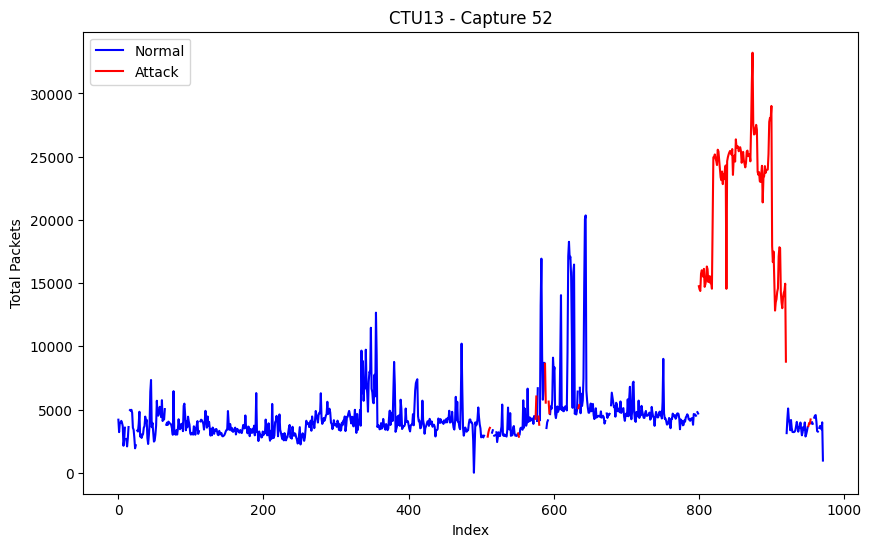

In [6]:
df = pd.read_csv("datasets/cap52processed.csv")

plt.figure(figsize=(10, 6))
plt.plot(df.index[:], df['total.pckts'][:].where(df['label'][:] == 0, np.nan), color='blue', label='Normal')
plt.plot(df.index[:], df['total.pckts'][:].where(df['label'][:] == 1, np.nan), color='red', label='Attack')
plt.title('CTU13 - Capture 52')
plt.xlabel('Index')
plt.ylabel('Total Packets')
plt.legend()
plt.show()

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972 entries, 0 to 971
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total.pckts           972 non-null    int64  
 1   tcp.pct               971 non-null    float64
 2   udp.pct               971 non-null    float64
 3   other.pct             971 non-null    float64
 4   ip.src.unique         972 non-null    int64  
 5   ip.dest.unique        972 non-null    int64  
 6   eth.src.unique        972 non-null    int64  
 7   eth.dest.unique       972 non-null    int64  
 8   pkt.length.mean       971 non-null    float64
 9   pkt.length.std        971 non-null    float64
 10  pkt.length.var        971 non-null    float64
 11  pkt.length.min        971 non-null    float64
 12  pkt.length.max        971 non-null    float64
 13  pkt.length.pquartil   971 non-null    float64
 14  pkt.length.med        971 non-null    float64
 15  pkt.length.tquartil   9

# Ordinal Pattern Trasformation

In [ ]:
# Features Matrix
matrix = []

# Drop unused columns
colunas = [coluna for coluna in df.columns if coluna not in ['timestamp', 'label']]

# Subset Delay (taux) and Dimension (dx)
taux = 1
dx = 3

# Time set
init = 0
end = # 5% of dataset
last = len(df)-end

In [ ]:
for i in range(0,last):
    # Features array
    vec = []
    vec.append([init, end])

    for feature in colunas:    
        # Entropy and Complexity from ordinal patterns
        tmp = ordpy.complexity_entropy(df[feature][init:end], dx=dx, taux=taux)
        vec.append(tmp[0])
        vec.append(tmp[1])
    
        # Fisher Shannon Information
        tmp = ordpy.fisher_shannon(df[feature][init:end], dx=dx, taux=taux)
        vec.append(tmp[1])
    
        # Transition graph transformation
        edges = ordpy.ordinal_network(df[feature][init:end], dx=dx, taux=taux)
    
        if len(edges[2]) > dx:
            # Graph entropy and complexity
            tmp = ordpy.complexity_entropy(edges[2], dx=dx, taux=taux)
            vec.append(tmp[0])
            vec.append(tmp[1])
            # Fisher information from graph
            tmp = ordpy.fisher_shannon(edges[2], dx=dx, taux=taux)
            vec.append(tmp[1])
        else:
            # 0 if len(edges) < dx
            vec.append(0)
            vec.append(0)
            vec.append(0)

        # Number of edges
        tmp = len(edges[1])
        vec.append(tmp)
    
        # Extraction of self-transition indices
        j=0
        indices = []
        for array in edges[1]:
            if(array[0] == array[1]):
                indices.append(j)
            j += 1
    
        # Calculation of the probability of self-transition
        prob = 0
        for index in indices:
            tmp = edges[2][index]
            prob += tmp
        vec.append(prob)

    # Label
    if (df['label'][end] == 1):
        vec.append(1)
    else:
        vec.append(0)

    # Add features to the matrix
    matrix.append(vec)
        
     # Time loop
    init += 1
    end += 1

    # Print progress
    clear_output(wait=True)
    print(f"{(i / last) * 100:.2f}%")

clear_output(wait=True)
print("100%")

In [ ]:
sufixos = ['entropy', 'complexity', 'fisher_shanon', 'edge_entropy', 'edge_complexity', 'edge_fisher_shannon', 'number_nodes', 'self_transition']

# Create column names
nomes_colunas = ['timestamp'] + [f'{col}_{sufixo}' for col in colunas for sufixo in sufixos] + ['label']

# Creates a dataframe with the matrix and column names
ft = pd.DataFrame(matrix, columns=nomes_colunas)

save_as = "capXX_ord_allfeatures.csv"  # Replace with the path and name of the file to be saved
ft.to_csv(save_as, sep=",", index=False)

print("Dataset successfully saved in:", save_as)

In [9]:
df = pd.read_csv("datasets/cap52_ord_allfeatures.csv")
df

,timestamp,total.pckts_entropy,total.pckts_complexity,total.pckts_fisher_shanon,total.pckts_edge_entropy,total.pckts_edge_complexity,total.pckts_edge_fisher_shannon,total.pckts_number_nodes,total.pckts_self_transition,tcp.pct_entropy,...,src.port.entropy_self_transition,tcp.seq.entropy_entropy,tcp.seq.entropy_complexity,tcp.seq.entropy_fisher_shanon,tcp.seq.entropy_edge_entropy,tcp.seq.entropy_edge_complexity,tcp.seq.entropy_edge_fisher_shannon,tcp.seq.entropy_number_nodes,tcp.seq.entropy_self_transition,label
0,"[0, 48]",0.951153,0.043141,0.032929,0.708816,0.244054,0.358241,17,0.288889,0.966052,...,0.288889,0.957419,0.041615,0.046890,0.920239,0.073710,0.102067,16,0.177778,0
1,"[1, 49]",0.951153,0.043141,0.030401,0.653546,0.255288,0.358987,16,0.288889,0.966052,...,0.288889,0.953332,0.045005,0.042415,0.836367,0.161715,0.225302,15,0.200000,0
2,"[2, 50]",0.943418,0.050768,0.041015,0.767991,0.195514,0.271991,16,0.288889,0.957090,...,0.266667,0.948141,0.049158,0.044177,0.806574,0.178115,0.375000,14,0.222222,0
3,"[3, 51]",0.938944,0.055395,0.044028,0.885036,0.097990,0.089860,15,0.288889,0.944673,...,0.288889,0.940198,0.055533,0.042238,0.846713,0.155188,0.199471,14,0.244444,0
4,"[4, 52]",0.920850,0.071115,0.062586,0.975664,0.024233,0.015567,14,0.288889,0.940198,...,0.288889,0.937132,0.059096,0.050536,0.822377,0.171154,0.214316,14,0.244444,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
919,"[919, 967]",0.953027,0.042522,0.027969,0.849835,0.115915,0.101721,17,0.266667,0.975038,...,0.088889,0.984246,0.015583,0.014688,0.954644,0.043299,0.055185,16,0.088889,0
920,"[920, 968]",0.959669,0.036335,0.024987,0.814552,0.172319,0.179120,17,0.266667,0.978809,...,0.088889,0.986278,0.013390,0.012397,0.878520,0.134683,0.152637,16,0.088889,0
921,"[921, 969]",0.957637,0.038419,0.020312,0.793985,0.181238,0.186909,18,0.266667,0.972595,...,0.066667,0.989538,0.010198,0.009152,0.878520,0.134683,0.152637,16,0.066667,0
922,"[922, 970]",0.961904,0.035316,0.020252,0.912376,0.075630,0.045169,18,0.266667,0.972595,...,0.066667,0.989538,0.010198,0.009152,0.954644,0.043299,0.055185,16,0.066667,0


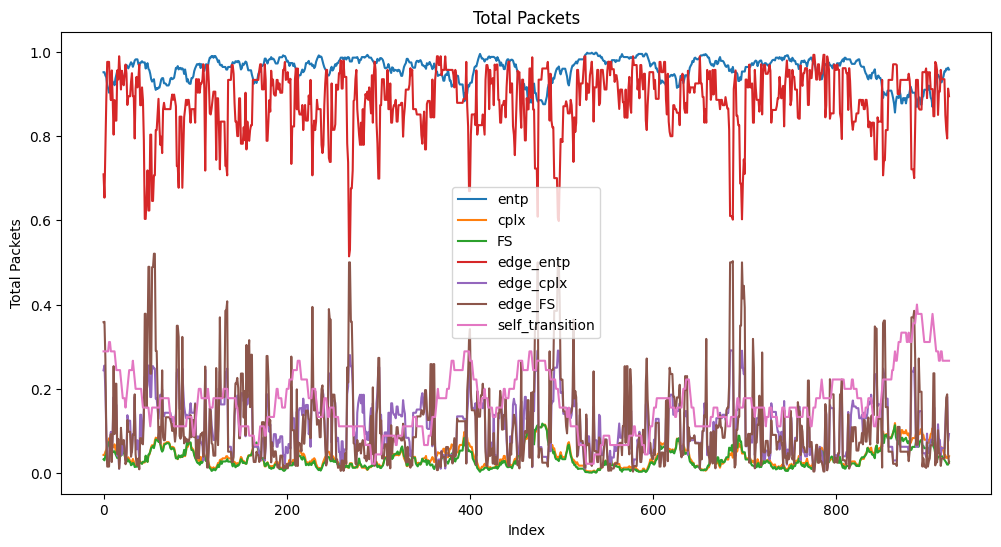

In [10]:
plt.figure(figsize=(12, 6))

plt.plot(df['total.pckts_entropy'], label= 'entp')
plt.plot(df['total.pckts_complexity'], label= 'cplx')
plt.plot(df['total.pckts_fisher_shanon'], label='FS')
plt.plot(df['total.pckts_edge_entropy'], label='edge_entp')
plt.plot(df['total.pckts_edge_complexity'], label='edge_cplx')
plt.plot(df['total.pckts_edge_fisher_shannon'], label='edge_FS')
#plt.plot(df['TP_number_nodes'], label ='number_nodes')
plt.plot(df['total.pckts_self_transition'], label ='self_transition')

plt.title('Total Packets')
plt.xlabel('Index')
plt.ylabel('Total Packets')

plt.legend()

plt.show()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924 entries, 0 to 923
Columns: 362 entries, timestamp to label
dtypes: float64(306), int64(55), object(1)
memory usage: 2.6+ MB


# Experiments

## CTU13 - Capture 51

In [35]:
df = pd.read_csv("datasets/cap51_tpo_infection.csv")
df

,timestamp,total.pckts_entropy,total.pckts_complexity,total.pckts_fisher_shanon,total.pckts_edge_entropy,total.pckts_edge_complexity,total.pckts_edge_fisher_shannon,total.pckts_number_nodes,total.pckts_self_transition,tcp.pct_entropy,...,src.port.entropy_self_transition,tcp.seq.entropy_entropy,tcp.seq.entropy_complexity,tcp.seq.entropy_fisher_shanon,tcp.seq.entropy_edge_entropy,tcp.seq.entropy_edge_complexity,tcp.seq.entropy_edge_fisher_shannon,tcp.seq.entropy_number_nodes,tcp.seq.entropy_self_transition,label
0,"[0, 440]",0.989474,0.010074,0.007067,0.912376,0.075630,0.055602,18,0.157895,0.995355,...,0.146453,0.996121,0.003736,0.002538,0.948880,0.050098,0.039775,18,0.123570,0
1,"[1, 441]",0.989903,0.009662,0.006873,0.912376,0.075630,0.055602,18,0.157895,0.995567,...,0.146453,0.996302,0.003555,0.002452,0.948880,0.050098,0.039775,18,0.121281,0
2,"[2, 442]",0.989944,0.009620,0.006533,0.912376,0.075630,0.055602,18,0.157895,0.995762,...,0.148741,0.996372,0.003486,0.002393,0.948880,0.050098,0.039775,18,0.121281,0
3,"[3, 443]",0.990490,0.009111,0.006320,0.894124,0.093033,0.070144,18,0.155606,0.995360,...,0.148741,0.995946,0.003891,0.002781,0.948880,0.050098,0.039775,18,0.121281,0
4,"[4, 444]",0.990984,0.008653,0.005941,0.912376,0.075630,0.055602,18,0.155606,0.995762,...,0.148741,0.996353,0.003506,0.002585,0.948880,0.050098,0.039775,18,0.118993,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5169,"[5169, 5609]",0.985653,0.014686,0.010667,0.960733,0.039983,0.013006,18,0.068650,0.991110,...,0.027460,0.998305,0.001672,0.001553,0.843353,0.160021,0.143121,18,0.118993,0
5170,"[5170, 5610]",0.986017,0.014346,0.010223,0.948880,0.050098,0.039775,18,0.068650,0.991385,...,0.027460,0.998177,0.001800,0.001706,0.843353,0.160021,0.143121,18,0.118993,0
5171,"[5171, 5611]",0.985848,0.014497,0.010645,0.948880,0.050098,0.039775,18,0.068650,0.991369,...,0.027460,0.998177,0.001800,0.001706,0.960733,0.039983,0.024391,18,0.118993,0
5172,"[5172, 5612]",0.985814,0.014528,0.010541,0.948880,0.050098,0.039775,18,0.068650,0.992046,...,0.027460,0.997883,0.002088,0.001935,0.960733,0.039983,0.024391,18,0.118993,0


In [36]:
# Remove malignant labels prior to infection
pd.options.mode.chained_assignment = None
df['label'].loc[:2203] = 0

In [37]:
methods = ["rfc", "lasso", "xgboost", "anova", "pca", 'relieff', 'multisurf', 'ig', 'pc']

# For each feature selection method
for method in methods:
    # Feature Selecion
    features = feature_selection(df, method, col_timestamp=True, alpha_value=0.2)
    
    matrix = []

    for i in range (1, len(features)+1):
        row = []
        # Execute experiment
        result = experiment(df, np.array(features['Feature'][:i]))
        row = [i] + result
        matrix.append(row)
        clear_output(wait=True)
        print(f"Method: {method}")
        print(features['Feature'][i-1])
        print(f"{i / len(features) * 100:.2f}%")

    # Save results
    result_df = pd.DataFrame(matrix, columns = ["n_features", "accuracy", "w_precision", "w_recall", "w_f1score", "predict_s"])

    result_df.to_csv(f"datasets/FS/cap51_tpo_{method}_results.csv", index=False)

Method: pc
tcp.seq.entropy_number_nodes
100.00%


In [38]:
# For the chi2 test, the input cannot contain negative values
df = df.apply(pd.to_numeric, errors='coerce')

# Find min value
min_values = df.min()

# Iterate over columns with negative values
for column in min_values.index[min_values < 0]:
    # Increment the smallest value found in the column
    df[column] += abs(min_values[column])

features = feature_selection(df, "chi2", col_timestamp = True)
    
matrix = []
    
for i in range (1, len(features)+1):
    row = []
    # Execute experiment
    result = experiment(df, np.array(features['Feature'][:i]))
    row = [i] + result
    matrix.append(row)
    clear_output(wait=True)
    print("Method: chi2")
    print(features['Feature'][i-1])
    print(f"{i / len(features) * 100:.2f}%")

    # Save results
    result_df = pd.DataFrame(matrix, columns = ["n_features", "accuracy", "w_precision", "w_recall", "w_f1score", "predict_s"])

    result_df.to_csv("datasets/FS/cap51_tpo_chi2_results.csv", index=False)

Method: chi2
pkt.delta.min_edge_fisher_shannon
100.00%


In [39]:
# Used in article
pca_results = pd.read_csv("datasets/FS/cap51_tpo_pca_results.csv")
anova_results = pd.read_csv("datasets/FS/cap51_tpo_anova_results.csv")
multisurf_results = pd.read_csv("datasets/FS/cap51_tpo_multisurf_results.csv")
lasso_results = pd.read_csv("datasets/FS/cap51_tpo_lasso_results.csv")
xgboost_results = pd.read_csv("datasets/FS/cap51_tpo_xgboost_results.csv")

# Out of the article
chi2_results = pd.read_csv("datasets/FS/cap51_tpo_chi2_results.csv")
ig_results = pd.read_csv("datasets/FS/cap51_tpo_ig_results.csv")
pc_results = pd.read_csv("datasets/FS/cap51_tpo_pc_results.csv")
relieff_results = pd.read_csv("datasets/FS/cap51_tpo_relieff_results.csv")
rfc_results = pd.read_csv("datasets/FS/cap51_tpo_rfc_results.csv")

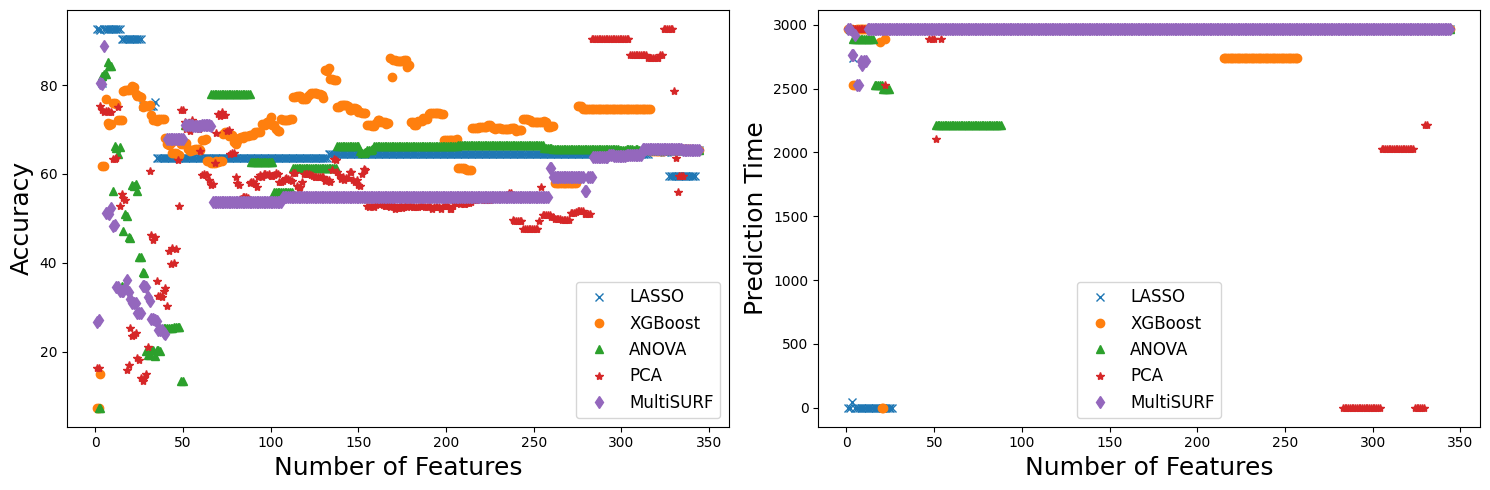

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

def plot_comparison(ax, column_name, ylabel):
    ax.plot(range(1, len(lasso_results) + 1), lasso_results[column_name], label='LASSO', marker='x', linestyle='None')
    #ax.plot(range(1, len(rfc_results) + 1), rfc_results[column_name], label='RFC')
    ax.plot(range(1, len(xgboost_results) + 1), xgboost_results[column_name], label='XGBoost', marker='o', linestyle='None')
    ax.plot(range(2, len(anova_results) + 1), anova_results[column_name][1:], label='ANOVA', marker='^', linestyle='None')
    ax.plot(range(1, len(pca_results) + 1), pca_results[column_name], label='PCA', marker='*', linestyle='None')
    #ax.plot(range(1, len(relieff_results) + 1), relieff_results[column_name], label='ReliefF')
    ax.plot(range(1, len(multisurf_results) + 1), multisurf_results[column_name], label='MultiSURF', marker='d', linestyle='None')
    #ax.plot(range(1, len(chi2_results) + 1), chi2_results[column_name], label='chi2')
    #ax.plot(range(1, len(ig_results) + 1), ig_results[column_name], label='Information Gain')
    #ax.plot(range(1, len(pc_results) + 1), pc_results[column_name], label='Pearson Correlation')
    ax.legend(fontsize=12)
    ax.set_xlabel('Number of Features', fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)

plot_comparison(axes[0], 'accuracy', "Accuracy")
#plot_comparison(axes[0, 1], 'w_precision', "Precisão Ponderada")
#plot_comparison(axes[1, 0], 'w_f1score', "F1-score Ponderado")
plot_comparison(axes[1], 'predict_s', "Prediction Time")

plt.tight_layout()

plt.savefig('datasets/FS/fs_ctu13_cap51_ctpo.pdf')

plt.show()

In [19]:
datasets = [
    ("pca", pca_results),
    ("anova", anova_results),
    ("multisurf", multisurf_results),
    ("lasso", lasso_results),
    ("xgboost", xgboost_results),
    ("chi2", chi2_results),
    ("information gain", ig_results),
    ("pearson correlation", pc_results),
    ("relieff", relieff_results),
    ("rfc", rfc_results)
]

max_combinations = {}
max_rows = {}

for dataset_name, dataset in datasets:
    max_combination = float('-inf')
    max_row = None
    
    for index, row in dataset.iterrows():
        combination = row['predict_s']# + row['accuracy']                                     # These conditions can be changed to filter the results
        if combination > max_combination and row['n_features'] < 50 and row['accuracy'] > 75: # These conditions can be changed to filter the results
            max_combination = combination
            max_row = row.copy()
            
    max_combinations[dataset_name] = max_combination
    max_rows[dataset_name] = max_row

best_dataset = max(max_combinations, key=max_combinations.get)

print("Best result for each dataset:")
for dataset_name, _ in datasets:
    print(f"Dataset: {dataset_name}")
    print(max_rows[dataset_name])

print("\nDataset with the greatest combination among all datasets:")
print(best_dataset)

Best result for each dataset:
Dataset: pca
n_features        3.000000
accuracy         75.425440
w_precision      85.237956
w_recall         75.425440
w_f1score        79.934112
predict_s      2968.000000
Name: 2, dtype: float64
Dataset: anova
n_features        4.000000
accuracy         82.145948
w_precision      87.704201
w_recall         82.145948
w_f1score        84.657272
predict_s      2889.000000
Name: 3, dtype: float64
Dataset: multisurf
n_features        5.000000
accuracy         88.895299
w_precision      87.637742
w_recall         88.895299
w_f1score        88.242378
predict_s      2919.000000
Name: 4, dtype: float64
Dataset: lasso
n_features       27.000000
accuracy         75.252380
w_precision      85.219524
w_recall         75.252380
w_f1score        79.826805
predict_s      2968.000000
Name: 26, dtype: float64
Dataset: xgboost
n_features        6.000000
accuracy         76.838766
w_precision      84.999776
w_recall         76.838766
w_f1score        80.674262
predict_s  

## CTU13 - Capture 52

In [20]:
df = pd.read_csv("datasets/cap52_tpo_infection.csv")
df

,timestamp,total.pckts_entropy,total.pckts_complexity,total.pckts_fisher_shanon,total.pckts_edge_entropy,total.pckts_edge_complexity,total.pckts_edge_fisher_shannon,total.pckts_number_nodes,total.pckts_self_transition,tcp.pct_entropy,...,src.port.entropy_self_transition,tcp.seq.entropy_entropy,tcp.seq.entropy_complexity,tcp.seq.entropy_fisher_shanon,tcp.seq.entropy_edge_entropy,tcp.seq.entropy_edge_complexity,tcp.seq.entropy_edge_fisher_shannon,tcp.seq.entropy_number_nodes,tcp.seq.entropy_self_transition,label
0,"[0, 48]",0.951153,0.043141,0.032929,0.708816,0.244054,0.358241,17,0.288889,0.966052,...,0.288889,0.957419,0.041615,0.046890,0.920239,0.073710,0.102067,16,0.177778,0
1,"[1, 49]",0.951153,0.043141,0.030401,0.653546,0.255288,0.358987,16,0.288889,0.966052,...,0.288889,0.953332,0.045005,0.042415,0.836367,0.161715,0.225302,15,0.200000,0
2,"[2, 50]",0.943418,0.050768,0.041015,0.767991,0.195514,0.271991,16,0.288889,0.957090,...,0.266667,0.948141,0.049158,0.044177,0.806574,0.178115,0.375000,14,0.222222,0
3,"[3, 51]",0.938944,0.055395,0.044028,0.885036,0.097990,0.089860,15,0.288889,0.944673,...,0.288889,0.940198,0.055533,0.042238,0.846713,0.155188,0.199471,14,0.244444,0
4,"[4, 52]",0.920850,0.071115,0.062586,0.975664,0.024233,0.015567,14,0.288889,0.940198,...,0.288889,0.937132,0.059096,0.050536,0.822377,0.171154,0.214316,14,0.244444,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
744,"[744, 792]",0.989538,0.010198,0.006624,0.918775,0.078219,0.036612,18,0.133333,0.972983,...,0.177778,0.944078,0.051913,0.040404,0.834042,0.163018,0.188064,16,0.222222,0
745,"[745, 793]",0.989538,0.010198,0.005287,0.948880,0.050098,0.041099,18,0.133333,0.966769,...,0.177778,0.934798,0.061666,0.050784,0.850955,0.154079,0.182228,15,0.222222,0
746,"[746, 794]",0.991277,0.008433,0.006613,0.978985,0.020031,0.023351,18,0.133333,0.972595,...,0.177778,0.934798,0.061666,0.050784,0.969987,0.030004,0.018255,15,0.222222,0
747,"[747, 795]",0.991277,0.008433,0.005101,0.940066,0.056241,0.047325,18,0.133333,0.975038,...,0.155556,0.951215,0.046500,0.034126,0.954644,0.043299,0.025599,16,0.222222,0


In [21]:
# Remove malignant labels prior to infection
pd.options.mode.chained_assignment = None
df['label'].loc[:479] = 0

In [22]:
methods = ["rfc", "lasso", "xgboost", "anova", "pca", 'relieff', 'multisurf', 'ig', 'pc']

# For each feature selection method
for method in methods:
    # Feature Selecion
    features = feature_selection(df, method, col_timestamp = True, alpha_value=0.2)
    
    matrix = []
    
    for i in range (1, len(features)+1):
        row = []
        # Execute experiment
        result = experiment(df, np.array(features['Feature'][:i]))
        row = [i] + result
        matrix.append(row)
        clear_output(wait=True)
        print(f"Method: {method}")
        print(features['Feature'][i-1])
        print(f"{i / len(features) * 100:.2f}%")

    # Save results
    result_df = pd.DataFrame(matrix, columns = ["n_features", "accuracy", "w_precision", "w_recall", "w_f1score", "predict_s"])

    result_df.to_csv(f"datasets/FS/cap52_tpo_{method}_results.csv", index=False)

Method: pc
tcp.flag.urg.count_self_transition
100.00%


In [23]:
# For the chi2 test, the input cannot contain negative values
df = df.apply(pd.to_numeric, errors='coerce')

# Find min value
min_values = df.min()

# Iterate over columns with negative values
for column in min_values.index[min_values < 0]:
    # Increment the smallest value found in the column
    df[column] += abs(min_values[column])

features = feature_selection(df, "chi2", col_timestamp = True)
    
matrix = []
    
for i in range (1, len(features)+1):
    row = []
    # Execute experiment
    result = experiment(df, np.array(features['Feature'][:i]))
    row = [i] + result
    matrix.append(row)
    clear_output(wait=True)
    print("Method: chi2")
    print(features['Feature'][i-1])
    print(f"{i / len(features) * 100:.2f}%")

    # Save results
    result_df = pd.DataFrame(matrix, columns = ["n_features", "accuracy", "w_precision", "w_recall", "w_f1score", "predict_s"])

    result_df.to_csv("datasets/FS/cap52_tpo_chi2_results.csv", index=False)

Method: chi2
tcp.flag.urg.count_edge_fisher_shannon
100.00%


In [24]:
# Used in article
pca_results = pd.read_csv("datasets/FS/cap52_tpo_pca_results.csv")
anova_results = pd.read_csv("datasets/FS/cap52_tpo_anova_results.csv")
multisurf_results = pd.read_csv("datasets/FS/cap52_tpo_multisurf_results.csv")
lasso_results = pd.read_csv("datasets/FS/cap52_tpo_lasso_results.csv")
xgboost_results = pd.read_csv("datasets/FS/cap52_tpo_xgboost_results.csv")

# Out of the article
chi2_results = pd.read_csv("datasets/FS/cap52_tpo_chi2_results.csv")
ig_results = pd.read_csv("datasets/FS/cap52_tpo_ig_results.csv")
pc_results = pd.read_csv("datasets/FS/cap52_tpo_pc_results.csv")
relieff_results = pd.read_csv("datasets/FS/cap52_tpo_relieff_results.csv")
rfc_results = pd.read_csv("datasets/FS/cap52_tpo_rfc_results.csv")

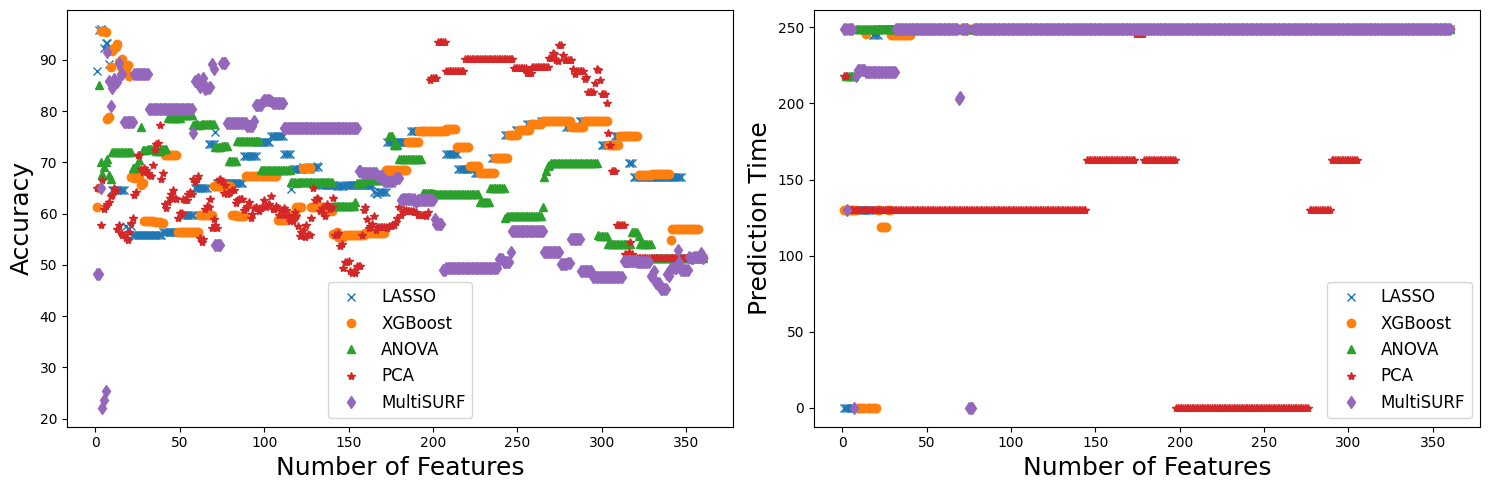

In [25]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

def plot_comparison(ax, column_name, ylabel):
    ax.plot(range(1, len(lasso_results) + 1), lasso_results[column_name], label='LASSO', marker='x', linestyle='None')
    #ax.plot(range(1, len(rfc_results) + 1), rfc_results[column_name], label='RFC')
    ax.plot(range(1, len(xgboost_results) + 1), xgboost_results[column_name], label='XGBoost', marker='o', linestyle='None')
    ax.plot(range(2, len(anova_results) + 1), anova_results[column_name][1:], label='ANOVA', marker='^', linestyle='None')
    ax.plot(range(1, len(pca_results) + 1), pca_results[column_name], label='PCA', marker='*', linestyle='None')
    #ax.plot(range(1, len(relieff_results) + 1), relieff_results[column_name], label='ReliefF')
    ax.plot(range(1, len(multisurf_results) + 1), multisurf_results[column_name], label='MultiSURF', marker='d', linestyle='None')
    #ax.plot(range(1, len(chi2_results) + 1), chi2_results[column_name], label='chi2')
    #ax.plot(range(1, len(ig_results) + 1), ig_results[column_name], label='Information Gain')
    #ax.plot(range(1, len(pc_results) + 1), pc_results[column_name], label='Pearson Correlation')
    ax.legend(fontsize=12)
    ax.set_xlabel('Number of Features', fontsize=18)
    ax.set_ylabel(ylabel, fontsize=18)

plot_comparison(axes[0], 'accuracy', "Accuracy")
#plot_comparison(axes[0, 1], 'w_precision', "Precision Weighted")
#plot_comparison(axes[1, 0], 'w_f1score', "F1-score Weighted")
plot_comparison(axes[1], 'predict_s', "Prediction Time")

plt.tight_layout()

plt.savefig('datasets/FS/fs_ctu13_cap52_ctpo.pdf')

plt.show()

In [26]:
datasets = [
    ("pca", pca_results),
    ("anova", anova_results),
    ("multisurf", multisurf_results),
    ("lasso", lasso_results),
    ("xgboost", xgboost_results),
    ("chi2", chi2_results),
    ("information gain", ig_results),
    ("pearson correlation", pc_results),
    ("relieff", relieff_results),
    ("rfc", rfc_results)
]

max_combinations = {}
max_rows = {}

for dataset_name, dataset in datasets:
    max_combination = float('-inf')
    max_row = None
    
    for index, row in dataset.iterrows():
        combination = row['predict_s'] + row['accuracy']                                    # These conditions can be changed to filter the results
        if combination > max_combination and row['accuracy'] > 80 and row['predict_s'] > 0: # These conditions can be changed to filter the results
            max_combination = combination
            max_row = row.copy()
            
    max_combinations[dataset_name] = max_combination
    max_rows[dataset_name] = max_row

best_dataset = max(max_combinations, key=max_combinations.get)

print("Best result for each dataset:")
for dataset_name, _ in datasets:
    print(f"Dataset: {dataset_name}")
    print(max_rows[dataset_name])

print("\nDataset with the greatest combination among all datasets:")
print(best_dataset)

Best result for each dataset:
Dataset: pca
n_features     297.000000
accuracy        88.247012
w_precision     94.486780
w_recall        88.247012
w_f1score       91.097316
predict_s      163.000000
Name: 296, dtype: float64
Dataset: anova
n_features       1.000000
accuracy        93.824701
w_precision     95.482864
w_recall        93.824701
w_f1score       94.579222
predict_s      218.000000
Name: 0, dtype: float64
Dataset: multisurf
n_features      64.000000
accuracy        86.454183
w_precision     95.403153
w_recall        86.454183
w_f1score       90.264120
predict_s      249.000000
Name: 63, dtype: float64
Dataset: lasso
n_features       8.000000
accuracy        89.243028
w_precision     93.749159
w_recall        89.243028
w_f1score       91.411929
predict_s      130.000000
Name: 7, dtype: float64
Dataset: xgboost
n_features      14.000000
accuracy        89.641434
w_precision     93.766902
w_recall        89.641434
w_f1score       91.631571
predict_s      246.000000
Name: 13, dt